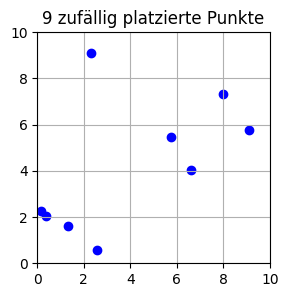

In [375]:
#%pip install numpy
#%pip install matplotlib

import numpy as np
import matplotlib.pyplot as plt

def plot():
    # Erstelle eine Grafik und plotte die Punkte
    plt.figure(figsize=(3, 3))
    plt.scatter(x, y, color='blue')  # Zeichne die Punkte als Scatterplot
    plt.xlim(0, 10)
    plt.ylim(0, 10)
    plt.grid(True)
    plt.title(f'{number_of_points} zufällig platzierte Punkte')
    plt.show()

# Anzahl der Punkte definieren
number_of_points = 9
# Erzeuge 'number_of_points' zufällige x- und y-Koordinaten im Bereich [0, 10]
x = np.random.rand(number_of_points) * 10
y = np.random.rand(number_of_points) * 10

plot()

# Kombiniere x und y zu Koordinatenpaaren
points = list(zip(x, y))


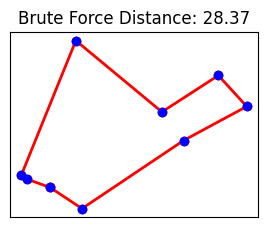

In [376]:
from itertools import permutations
import math

def plot_brute_force():
    # Erstelle eine Grafik und plotte die Punkte
    plt.clf()  # Aktuelle Grafik löschen

    # Extrahiere die x- und y-Koordinaten aller Punkte und plote sie als blauen Scatterplot.
    x_coords = [p[0] for p in points]
    y_coords = [p[1] for p in points]
    plt.scatter(x_coords, y_coords, color='blue', zorder=3)

    # Erstelle Listen für die x- und y-Koordinaten der Route.
    # Schließe die Route, indem du den Startpunkt am Ende wieder hinzufügst.
    xs = [p[0] for p in best_route_local] + [best_route_local[0][0]]
    ys = [p[1] for p in best_route_local] + [best_route_local[0][1]]
    # Verbinde die Punkte der Route mit einer roten Linie und markiere jeden Punkt.
    plt.plot(xs, ys, color='red', linewidth=2, marker='o')

    # Füge einen Titel hinzu, der die Gesamtdistanz der Route anzeigt.
    plt.title(f"Brute Force Distance: {best_distance:.2f}")

    # Entferne die Achsenbeschriftungen.
    plt.xticks([])
    plt.yticks([])

    fig = plt.gcf()
    fig.set_size_inches(fig.get_size_inches() * 0.5)
    plt.savefig("brute_force.png", dpi=300, format="png", bbox_inches="tight")
    plt.show()

# Vereinfachte Distanzfunktion unter Verwendung von math.dist.
def route_distance(route):
    # Für eine gegebene Route berechnen wir die Gesamtdistanz,
    # indem wir die Distanzen zwischen jedem aufeinanderfolgenden Punktpaar aufsummieren.
    # Dabei wird math.dist() verwendet, um die euklidische Distanz zwischen zwei Punkten zu berechnen.
    d = sum(math.dist(route[i], route[i+1]) for i in range(len(route)-1))
    
    # Abschließend wird die Distanz vom letzten Punkt zurück zum Startpunkt addiert,
    # um den Rundweg zu schließen.
    return d + math.dist(route[-1], route[0])


best_distance = math.inf # Initialisiere best_distance mit unendlich, sodass jede berechnete Route kürzer ist.
best_route_local = None

# Suche die beste Route, indem alle Permutationen geprüft werden | https://docs.python.org/3/library/itertools.html 
for route in permutations(points): # r-Länge, alle möglichen Permutationen ohne wiederholte Elemente
    d_current = route_distance(route)
    if d_current < best_distance:
        best_distance = d_current
        best_route_local = route
# FRAGE : Wie ist die Laufzeit dieser Funktion? | O(n!) https://de.wikipedia.org/wiki/Fakult%C3%A4t_(Mathematik)

plot_brute_force()


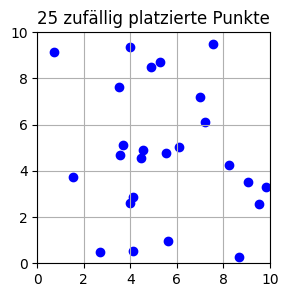

In [377]:
#%pip install numpy
#%pip install matplotlib

import numpy as np
import matplotlib.pyplot as plt

# Anzahl der Punkte definieren
number_of_points = 25
# Erzeuge 'number_of_points' zufällige x- und y-Koordinaten im Bereich [0, 10]
x = np.random.rand(number_of_points) * 10
y = np.random.rand(number_of_points) * 10

# Erstelle eine Grafik und plotte die Punkte
plt.figure(figsize=(3, 3))
plt.scatter(x, y, color='blue')  # Zeichne die Punkte als Scatterplot
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.grid(True)
plt.title(f'{number_of_points} zufällig platzierte Punkte')
plt.show()

# Kombiniere x und y zu Koordinatenpaaren
points = list(zip(x, y))

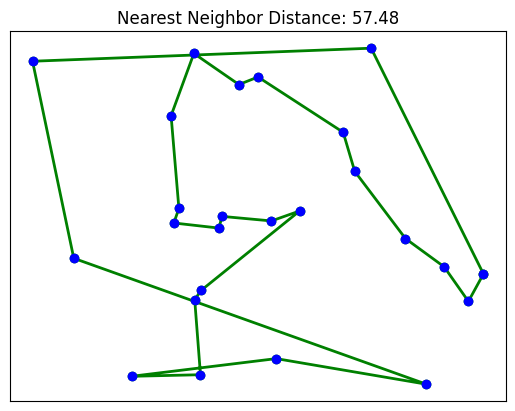

In [378]:
from IPython.display import display

def plot_nearest_neighbor():
    # Plotten der Nearest-Neighbor-Route:
    plt.clf()  # Aktuelle Grafik löschen
    # Extrahiere die x- und y-Koordinaten aller Punkte und plote sie als blauen Scatterplot.
    x_coords = [p[0] for p in points]
    y_coords = [p[1] for p in points]
    plt.scatter(x_coords, y_coords, color='blue', zorder=5)

    # Erstelle Listen für die x- und y-Koordinaten der Route.
    # Schließe die Route, indem du den Startpunkt am Ende wieder hinzufügst.
    xs_nn = [p[0] for p in nn_route] + [nn_route[0][0]]
    ys_nn = [p[1] for p in nn_route] + [nn_route[0][1]]
    # Verbinde die Punkte der Route mit einer grünen Linie und markiere jeden Punkt.
    plt.plot(xs_nn, ys_nn, color='green', linewidth=2, marker='o')

    # Füge einen Titel hinzu, der die Gesamtdistanz der Route anzeigt.
    plt.title(f"Nearest Neighbor Distance: {nn_distance:.2f}")

    # Entferne die Achsenbeschriftungen.
    plt.xticks([])
    plt.yticks([])
    plt.savefig("nearest_neighbor.png", dpi=300, format="png", bbox_inches="tight")
    plt.show()

def nearest_neighbor(points):
    # Falls keine Punkte vorhanden sind, gebe eine leere Liste zurück.
    if not points:
        return []
    
    route = [points[0]]    # Beginne die Route mit dem ersten Punkt.
    
    remaining_points = points[1:] # Erstelle eine Liste der noch nicht besuchten Punkte (außer dem Startpunkt).
    
    # Solange noch Punkte übrig sind:
    while remaining_points:
        # Der aktuelle Punkt ist immer der letzte in der Route.
        current = route[-1]
        # Finde den nächsten Punkt, der am nächsten zum aktuellen liegt.
        nearest = min(remaining_points, key=lambda p: math.dist(current, p))
        # Füge diesen Punkt der Route hinzu.
        route.append(nearest)
        # Entferne den neu besuchten Punkt aus der Liste der verbleibenden Punkte.
        remaining_points.remove(nearest)
    
    return route
    # FRAGE : Wie ist die Laufzeit dieser Funktion? | O(n^2) wesentlich schneller als o(n!)

nn_route = nearest_neighbor(points) # Berechne die Route

nn_distance = route_distance(nn_route) # Berechne die Gesamtdistanz der gefundenen Route, inklusive Rückweg zum Startpunkt.


plot_nearest_neighbor()



In [ ]:
from ipywidgets import Play, IntSlider, jslink, VBox, Output
from IPython.display import display

# Create an output widget for the animation.
out = Output()

play = Play(
    value=0,
    min=0,
    max=len(nn_route),
    step=1,
    interval=500
)

slider = IntSlider(
    value=0,
    min=0,
    max=len(nn_route),
    step=1
)

jslink((play, 'value'), (slider, 'value'))

def animate_nn(i):
    plt.clf()
    # Plot all points as blue scatterplot.
    x_coords = [p[0] for p in points]
    y_coords = [p[1] for p in points]
    plt.scatter(x_coords, y_coords, color='blue', zorder=5)
    
    # Plot the partial route from the nearest neighbor route.
    if i > 0:
        xs = [p[0] for p in nn_route[:i]]
        ys = [p[1] for p in nn_route[:i]]
        if i == len(nn_route):
            xs.append(nn_route[0][0])
            ys.append(nn_route[0][1])
        plt.plot(xs, ys, color='green', linewidth=2, marker='o')
        
        # Visualize the query from the current point to all remaining points.
        current_point = nn_route[i-1]
        # Determine remaining points (unvisited points)
        remaining = [p for p in points if p not in nn_route[:i]]
        for candidate in remaining:
            plt.plot([current_point[0], candidate[0]], [current_point[1], candidate[1]], 
                     color='orange', linestyle='--', linewidth=1)
    
    # Remove the axis labels.
    plt.xticks([])
    plt.yticks([])
    plt.show()

def on_slider_change(change):
    with out:
        out.clear_output(wait=True)
        animate_nn(change['new'])

slider.observe(on_slider_change, names='value')

display(VBox([play, slider, out]))


Christofides Distance: 46.98867977009028


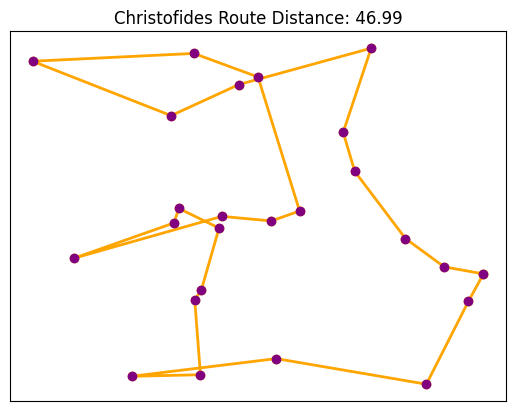

In [380]:
# Die Funktion euclidean berechnet die Euklidische Distanz zwischen zwei Punkten,
# die im globalen Array 'points' an den Indizes i und j liegen.
def euclidean(i, j):
    """Berechnet die euklidische Distanz zwischen points[i] und points[j].
    
    Parameter:
      i (int): Index des ersten Punktes in der Liste 'points'
      j (int): Index des zweiten Punktes in der Liste 'points'
    
    Rückgabe:
      float: Euklidische Distanz zwischen den beiden Punkten.
    """
    # math.dist berechnet die Distanz zwischen zwei iterierbaren Objekten, z.B. Tupel
    return math.dist(points[i], points[j])

# Die Funktion compute_MST konstruiert einen minimal aufspannenden Baum (MST)
# für einen vollständigen Graphen aller Punkte mittels Prim's Algorithmus.
def compute_MST(n):
    """Berechnet den minimal aufspannenden Baum (MST) für einen vollständigen Graphen 
       der Punkte (Index 0 bis n-1) mittels Prim's Algorithmus.
    
    Parameter:
      n (int): Anzahl der Punkte im Graphen.
      
    Rückgabe:
      list: Liste von Kanten, die den MST darstellen. Jede Kante ist ein Tupel (u, v).
    """
    mst_edges = []            # Liste zur Speicherung der Kanten, die im MST enthalten sind.
    in_tree = [False] * n      # Boolean-Liste zur Markierung, ob ein Knoten bereits im MST enthalten ist.
    in_tree[0] = True          # Beginne den MST mit Knoten 0.
    
    edges = []                # Liste zur Speicherung potentieller Kanten (Gewicht, u, v).
    # Füge alle Kanten vom Startknoten (0) zu jedem anderen Knoten hinzu.
    for j in range(1, n):
        edges.append((euclidean(0, j), 0, j))
    
    # Wiederholen, bis alle Knoten dem MST hinzugefügt wurden
    for _ in range(n - 1):
        # Sortiere die Kantenliste nach Gewicht, um immer die Kante mit minimalem Gewicht zu wählen.
        edges.sort(key=lambda x: x[0])
        # Durchlaufe die Kanten, um eine zu finden, deren Endknoten noch nicht im MST enthalten ist.
        for weight, u, v in edges:
            if in_tree[u] and not in_tree[v]:
                # Füge die Kante dem MST hinzu
                mst_edges.append((u, v))
                # Markiere Knoten v als im MST enthalten
                in_tree[v] = True
                # Füge alle Kanten von dem neu hinzugefügten Knoten zu den noch nicht aufgenommenen Knoten hinzu.
                for k in range(n):
                    if not in_tree[k]:
                        edges.append((euclidean(v, k), v, k))
                # Da eine gültige Kante gefunden wurde, brechen wir die Schleife ab und starten den nächsten Schritt.
                break
    return mst_edges

# Die Funktion get_odd_vertices ermittelt die Knoten im gegebenen MST, 
# deren Grad (Anzahl an angrenzenden Kanten) ungerade ist.
def get_odd_vertices(mst_edges, n):
    """Ermittelt die Knoten im MST mit ungeradem Grad.
    
    Parameter:
      mst_edges (list): Liste der Kanten im MST, jedes Element ist ein Tupel (u, v).
      n (int): Anzahl der Knoten.
    
    Rückgabe:
      list: Liste der Knotenindizes mit ungeradem Grad.
    """
    degree = [0] * n   # Array zur Speicherung der Gradanzahl für jeden Knoten.
    
    # Für jede Kante im MST erhöhen wir den Grad beider beteiligter Knoten.
    for u, v in mst_edges:
        degree[u] += 1
        degree[v] += 1
    
    # Erstelle eine Liste aller Knoten, deren Grad ungerade ist.
    odd_vertices = [i for i in range(n) if degree[i] % 2 == 1]
    return odd_vertices

# Die Funktion min_weight_perfect_matching berechnet das minimale perfekte Matching
# der Knoten mit ungeradem Grad mittels rekursiver Backtracking-Suche.
def min_weight_perfect_matching(odd_vertices):
    """Berechnet per rekursiver Backtracking-Suche das minimale perfekte Matching 
       der ungeraden Knoten.
    
    Parameter:
      odd_vertices (list): Liste der Knotenindizes mit ungeradem Grad.
    
    Rückgabe:
      list: Liste von Kanten (Tupel), die das Matching darstellen.
    """
    best_matching = None         # Variable zur Speicherung des besten Matching (mit minimalem Gesamtgewicht).
    best_weight = math.inf         # Initialisiere das beste Gewicht als unendlich.
    
    # Rekursive Hilfsfunktion, um alle möglichen Matchings zu untersuchen.
    def match_recursive(matching, unmatched, weight_so_far):
        nonlocal best_matching, best_weight
        # Wenn keine ungematchten Knoten mehr vorhanden sind, prüfen wir das gefundene Matching.
        if not unmatched:
            if weight_so_far < best_weight:
                best_weight = weight_so_far
                best_matching = matching.copy()  # Speichere das aktuelle Matching als bestes gefundenes.
            return
        
        # Wähle den ersten ungematchten Knoten
        i = unmatched[0]
        # Versuche, i mit jedem der verbleibenden ungematchten Knoten zu matchen
        for j in unmatched[1:]:
            # Berechne die Distanz zwischen Knoten i und j als Gewicht des Paares.
            pair_weight = euclidean(i, j)
            # Erstelle eine Kopie der Liste der ungematchten Knoten und entferne i und j daraus.
            new_unmatched = unmatched.copy()
            new_unmatched.remove(i)
            new_unmatched.remove(j)
            # Führe die rekursive Suche fort, indem das aktuelle Paar zum Matching hinzugefügt wird.
            match_recursive(matching + [(i, j)], new_unmatched, weight_so_far + pair_weight)
    
    # Starte die rekursive Suche mit einem leeren Matching, allen ungematchten Knoten und null anfänglichem Gewicht.
    match_recursive([], odd_vertices, 0)
    return best_matching

# Die Funktion create_multigraph erstellt einen Multigraph, indem sie den MST und 
# das perfekte Matching kombiniert. Das Ergebnis ist eine Nachbarschaftsliste.
def create_multigraph(n, mst_edges, matching):
    """Erstellt aus den MST-Kanten und dem Matching einen Multigraphen als Nachbarschaftsliste.
    
    Parameter:
      n (int): Anzahl der Knoten.
      mst_edges (list): Kanten des MST.
      matching (list): Kanten des perfekten Matchings.
    
    Rückgabe:
      dict: Dictionary, wobei jeder Schlüssel (Knotenindex) eine Liste von benachbarten Knoten hat.
    """
    # Initialisiere den Graphen als Dictionary, in dem jeder Knoten einer leeren Nachbarschaftsliste zugeordnet ist.
    graph = {i: [] for i in range(n)}
    # Füge alle MST-Kanten hinzu, da sie ungerichtet sind, wird jeder Kante in beiden Richtungen hinzugefügt.
    for u, v in mst_edges:
        graph[u].append(v)
        graph[v].append(u)
    # Füge zusätzlich die Kanten aus dem perfekten Matching hinzu.
    for u, v in matching:
        graph[u].append(v)
        graph[v].append(u)
    return graph

# Die Funktion find_eulerian_tour sucht in einem Eulergraphen mithilfe des Hierholzer-Algorithmus 
# einen Eulerkreis. Ein Eulerkreis ist ein Rundgang, der jede Kante genau einmal durchläuft.
def find_eulerian_tour(graph):
    """Findet mit Hierholzer Algorithmus einen eulerischen Rundgang im gegebenen Graphen.
    
    Parameter:
      graph (dict): Nachbarschaftsliste des Graphen.
    
    Rückgabe:
      list: Liste der Knoten, die den eulerischen Rundgang in der berechneten Reihenfolge darstellen.
    """
    # Erstelle eine Kopie des Graphen, um die Originalstruktur nicht zu verändern.
    graph_copy = {u: graph[u].copy() for u in graph}
    tour = []    # Liste zum Speichern des Eulerkreises.
    stack = [0]  # Startpunkt des Rundgangs ist Knoten 0.
    
    # Solange es noch Knoten im Stack gibt, wird der Algorithmus fortgesetzt.
    while stack:
        u = stack[-1]
        if graph_copy[u]:
            # Existieren noch benachbarte Knoten, wird die erste gefundene Kante gewählt.
            v = graph_copy[u].pop()  # Kante (u, v) wird "besucht".
            stack.append(v)          # Füge v zum aktuellen Rundgang hinzu.
            # Entferne die Rückkante (v, u) aus dem Graphen, weil der Graph ungerichtet ist.
            graph_copy[v].remove(u)
        else:
            # Wenn es keine weiteren benachbarten Knoten gibt, wird der Knoten dem Rundgang hinzugefügt.
            tour.append(stack.pop())
    # Die Rückgabe erfolgt in der korrekten Reihenfolge des Rundgangs.
    return tour[::-1]

# Die Funktion shortcut_eulerian wandelt einen Eulerkreis in einen Hamiltonkreis um,
# indem sie wiederholte Knoten überspringt. Dadurch wird sichergestellt, dass jeder Knoten
# nur einmal besucht wird (außer dem Start-/Endknoten).
def shortcut_eulerian(tour):
    """Umwandlung eines eulerischen Rundgangs in einen Hamiltonkreis durch Überspringen wiederholter Knoten.
    
    Parameter:
      tour (list): Liste der Knoten des Eulerkreises.
    
    Rückgabe:
      list: Liste der Knoten des resultierenden Hamiltonkreises.
    """
    visited = set()  # Set zur Speicherung bereits besuchter Knoten
    path = []        # Liste zur Speicherung des endgültigen Hamiltonkreises
    # Gehe die Reihenfolge der Knoten im Eulerkreis durch
    for vertex in tour:
        # Nur Knoten hinzufügen, die noch nicht besucht wurden
        if vertex not in visited:
            visited.add(vertex)
            path.append(vertex)
    # Schließe den Kreis, indem der Startknoten wieder angehängt wird.
    path.append(path[0])
    return path

# Die Funktion christofides_route implementiert den Christofides-Algorithmus zur Näherungslösung
# des Traveling Salesman Problem (TSP). Dabei werden die zuvor definierten Funktionen kombiniert.
def christofides_route():
    """Berechnet mithilfe des Christofides Algorithmus eine Näherungslösung zum TSP.
    
       Rückgabe:
         route_coords (list): Liste der Punktekoordinaten des gefundenen Hamiltonkreises.
         total_distance (float): Gesamtdistanz des berechneten Zykels.
    """
    n = len(points)  # Anzahl der Punkte im globalen Array 'points'
    
    # Berechne den minimal aufspannenden Baum (MST) der Punkte.
    mst_edges = compute_MST(n)
    
    # Ermittle die Knoten, die im MST einen ungeraden Grad besitzen.
    odd_vertices = get_odd_vertices(mst_edges, n)
    
    # Berechne das perfekte Matching der ungeraden Knoten. Falls es keine ungeraden Knoten gibt, bleibt das Matching leer.
    matching = min_weight_perfect_matching(odd_vertices) if odd_vertices else []
    
    # Erstelle einen Multigraphen, der MST und Matching zusammenfasst.
    multigraph = create_multigraph(n, mst_edges, matching)
    
    # Finde einen Eulerkreis im Multigraph mittels Hierholzer Algorithmus.
    eulerian_tour = find_eulerian_tour(multigraph)
    
    # Erzeuge einen Hamiltonkreis, indem im Eulerkreis wiederholte Knoten übersprungen werden.
    hamiltonian = shortcut_eulerian(eulerian_tour)
    
    # Ermittle die Koordinaten der Punkte des Hamiltonkreises.
    route_coords = [points[i] for i in hamiltonian]
    
    # Berechne die Gesamtdistanz des Hamiltonkreises, indem die Distanzen aufeinanderfolgender Punkte summiert werden.
    total_distance = sum(math.dist(route_coords[i], route_coords[i+1]) for i in range(len(route_coords)-1))
    return route_coords, total_distance

# Führe den Christofides-Algorithmus aus und erhalte die Route und die Gesamtdistanz.
christofides_route_coords, christofides_distance = christofides_route()
print("Christofides Distance:", christofides_distance)

# Die Funktion plot_christofides visualisiert die berechnete Route neben den ursprünglichen Punkten.
def plot_christofides():
    """Plottet die durch Christofides berechnete Route im Vergleich zu den Punkten."""
    # Lösche die vorherige Grafik, falls vorhanden.
    plt.clf()
    
    # Bereite die x- und y-Koordinaten der Route vor.
    xs = [p[0] for p in christofides_route_coords]
    ys = [p[1] for p in christofides_route_coords]
    
    # Erstelle einen Scatter-Plot für alle Punkte in lila, um die ursprüngliche Punktwolke darzustellen.
    x_coords = [p[0] for p in points]
    y_coords = [p[1] for p in points]
    plt.scatter(x_coords, y_coords, color='purple', zorder=3)
    
    # Zeichne den Hamiltonkreis (Route) in orange, verbunden durch Linien und markiere die Punkte mit Kreisen.
    plt.plot(xs, ys, color='orange', linewidth=2, marker='o')
    
    # Setze den Titel des Plots auf die Gesamtdistanz der berechneten Route (mit zwei Dezimalstellen).
    plt.title(f"Christofides Route Distance: {christofides_distance:.2f}")
    
    # Entferne die Achsenbeschriftungen, um den Fokus auf die Route zu legen.
    plt.xticks([])
    plt.yticks([])
    plt.savefig("christofides.png", dpi=300, format="png", bbox_inches="tight")
    plt.show()

# Zeichne die berechnete Route
plot_christofides()